## CS 401 Applied Data Analysis, 2018 autumn
## Final Project: Media Polarity in the Presidential Election
##### Group Members: Ruibin Huang, Liangwei Chen, Fengyu Cai

Data Story：https://rhuangag.github.io/DataStory/

### Objective:
In this project, we would like to dig up the potential media polarity about the news on the websites. Through the year, we hope to find out the bias for some media as to some specific topics.

### Main Step
- Label the news with keywords or topic
    - TF-IDF
- Select specific news and medias for analysis in the similar time and topic
    - NLTK sentiment analysis package
- Further analyze based on the chronological and geometrical features of the medias
    - map or plot

Technologies applied (and will be applied): spark, Machine Learning, NLTK, Web Crawling

### About Datasets:
1. News Source: containing News IDs, Publisher, Publish Date, Publish Region, Publish Organization, News URL and News Title
2. News Excerpt: containing excerpts of website HTML, responding to the NEWs ID.
3. News parse and stemming: containing the canonical steming form of the news, which is convenient for manipulation and search.

In [1]:
# Import Module
import sys
import os
import re
import gc
import string
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict

# For the Topic-selection
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# NLP
import spacy
import gensim

# For Website Crawling
from bs4 import BeautifulSoup
import requests

# For Sentimental Analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from textblob import TextBlob
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

# For the word frequeny visualization
import wordcloud

# For interative plot
import plotly.plotly as py
import plotly.graph_objs as go

/home/fcai/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


### Part 1: Preprocess Data

In [2]:
# data path
stm_file = '16-10-us.txt'
alter_file = '16-10-us-clean.txt'
src_file = 'now_sources_pt2.txt'
txt_file = '16-10-us-txt.txt'
src_folder = 'source'

##### 1.1 Stemming File Clean:
As we find in the News Stemming File, there exits some illegal characters, therefore, we need to filter to get the pure data.

1.1.1 Encoding Issue

In [3]:
# remove the punctuations in the text, and replace them to N/A
with open(stm_file, 'r', errors='replace', encoding='utf-8') as f:
    with open(alter_file ,'w') as w:
        w.write(re.sub('\t[' + string.punctuation + ']\t', '\tN/A\t', f.read()))

1.1.2 Select the write format data

In [4]:
id_c = re.compile(r'\d+')
getId = lambda line: id_c.match(line).group(0)

In [205]:
colnames=['doc_id', 'word_id', 'word', 'origin_word', 'pos'] 
stemming_pd = pd.read_csv(alter_file, sep='\t', error_bad_lines=False, engine='python', header=None, names=colnames)

In [6]:
# the stemmed result
stemming_pd.head(10)

,doc_id,word_id,word,origin_word,pos
0,14637197,4739839025,@@14637197,NaN,fo
1,14637197,4739839026,<p>,NaN,null
2,14637197,4739839027,NEW,new,np1
3,14637197,4739839028,YORK,york,np1
4,14637197,4739839029,NaN,NaN,(
5,14637197,4739839030,AP,ap,np1
6,14637197,4739839031,NaN,NaN,)
7,14637197,4739839032,--,NaN,jj_nn1
8,14637197,4739839033,Donald,donald,np1
9,14637197,4739839034,Trump,trump,nn1


In [7]:
# remove N/A (including punctuations)
stemming_pd.dropna(inplace=True)

In [8]:
# after drop NA
stemming_pd.head(10)

,doc_id,word_id,word,origin_word,pos
2,14637197,4739839027,NEW,new,np1
3,14637197,4739839028,YORK,york,np1
5,14637197,4739839030,AP,ap,np1
8,14637197,4739839033,Donald,donald,np1
9,14637197,4739839034,Trump,trump,nn1
10,14637197,4739839035,'s,'s,ge
11,14637197,4739839036,five-day,five-day,jj
12,14637197,4739839037,feud,feud,nn1
13,14637197,4739839038,with,with,iw
14,14637197,4739839039,a,a,at1


In [9]:
# cleaned text by eliminating punctuations and illegal characters
stemming_list = stemming_pd.groupby('doc_id')['origin_word'].apply(list).apply(lambda x: ' '.join(x))

In [10]:
pd.DataFrame(stemming_list).head()

,origin_word
doc_id,
14637197,new york ap donald trump 's five-day feud with...
14637200,here be all the crazy stuff that happen at the...
14637201,another hotel want to build in the heart of ho...
14637202,in this sept 23 2016 photo rick retail sales m...
14637203,court erase jury award of punitive damage agai...


##### 1.2 Load the data Source

1.2.1 load new source data

In [11]:
new_src = pd.read_csv(os.path.join(src_folder, src_file), delimiter="\t", header=None, encoding = "ISO-8859-1")

In [12]:
new_src.columns=['id','unknown','date','country','media','website','title']

In [13]:
new_src.head(3)

,id,unknown,date,country,media,website,title
0,2930853,194,15-01-01,US,Consequence of Sound,http://consequenceofsound.net/2015/01/100000-c...,100000 copies of The Interview will be dropped...
1,2930854,266,15-01-01,US,Los Angeles Times,http://www.latimes.com/entertainment/movies/la...,'The Taking of Tiger Mountain' gets blockbuste...
2,2930855,701,15-01-01,US,TIME,http://time.com/3651697/afghanistan-war-cost/,The True Cost of the Afghanistan War May Surpr...


unite the names of main medias in US

In [14]:
# unite the names of main medias in US
US_media=new_src[new_src['country']=='US']
# Google search the top 30 medias https://www.allyoucanread.com/american-newspapers/
US_top_30_media = ['CNN', 'New York Times', 'Washington Post', 'Breitbart News','Fox News','Huffington Post','VICE' ,'USA TODAY', 'NPR','CBS News'
                  ,'Houston Chronicle', 'NBC News','Politico','The Atlantic','TIME',  'Newsweek', 'ABC News','Reuters','Slate Magazine','Daily Beast', 
                  'Los Angeles Times','Quartz',  'New York Post']
# observe that the same media may have different names
US_media[US_media['media'].str.contains('fox')].head(3)

,id,unknown,date,country,media,website,title
212,2932333,667,15-01-02,US,fox6now.com,http://fox6now.com/2015/01/02/southeast-wiscon...,Southeast Wisconsin to see first accumulating ...
305,2932466,316,15-01-02,US,fox4kc.com,http://fox4kc.com/2015/01/02/man-accused-of-ra...,"Man accused of raping, robbing 67-year-old wom..."
1212,2941832,380,15-01-07,US,fox5sandiego.com,http://fox5sandiego.com/2015/01/07/seaworld-pl...,SeaWorld plans to double size of orca tank


In [15]:
# unite the names, here is an example, we do the same replacement for all the media in the top 30 list
US_media['media']=US_media['media'].apply(lambda x: 'Fox News' if 'fox'in x.lower() else x)
# store the result in a csv file
US_media.to_csv('top30media.csv')

/home/fcai/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [16]:
# check the result
new_src = pd.read_csv('top30mediaUS.csv').drop(['Unnamed: 0'],axis=1)
new_src[new_src['media'].str.contains('fox')]

,id,unknown,date,country,media,website,title


In [17]:
new_src[new_src['media'].str.contains('Fox')].head(3)

,id,unknown,date,country,media,website,title
212,2932333,667,15-01-02,US,Fox News,http://fox6now.com/2015/01/02/southeast-wiscon...,Southeast Wisconsin to see first accumulating ...
284,2932437,492,15-01-02,US,Fox News,http://www.foxbusiness.com/industries/2015/01/...,2015 Investment Playbook: Profiting from the '...
305,2932466,316,15-01-02,US,Fox News,http://fox4kc.com/2015/01/02/man-accused-of-ra...,"Man accused of raping, robbing 67-year-old wom..."


statistical analysis on the data

In [18]:
# total number of the medias
new_src.groupby('media').count().sort_values(by='id').drop(['unknown','date','country','website','title'],axis=1)['id'].count()

7302

In [19]:
# choose the medias which are in the top 30 list
mask = new_src['media'].isin(US_top_30_media)
top30_media = new_src[mask]

In [20]:
top30_media=top30_media.groupby('media').count().sort_values(by='id').drop(['unknown','date','country','website','title'],axis=1)
top30_media.columns =['Frequence']

In [21]:
# print out the frequence of news of the top 30 medias
top30_media

,Frequence
media,
Houston Chronicle,133
Newsweek,206
New York Times,242
VICE,402
Breitbart News,546
Politico,739
Daily Beast,750
The Atlantic,1093
Washington Post,1556


In [22]:
top30_media.to_csv('top30media_freq.csv')

In [23]:
# remove the media with a frequence lower than 700 from the old list
US_top_30_media = ['CNN', 'Washington Post', 'Fox News','Huffington Post' ,'USA TODAY', 'NPR','CBS News'
                  , 'NBC News','Politico','The Atlantic','TIME',  'ABC News','Reuters','Slate Magazine','Daily Beast', 
                  'Los Angeles Times','Quartz',  'New York Post']

In [24]:
# filter the data using the new list
mask = new_src['media'].isin(US_top_30_media)
new_src = new_src[mask]

1.2.2 Data filtering and selection

In [25]:
new_src['year'], new_src['month'], new_src['day'] = new_src['date'].str.split('-', 2).str

In [26]:
new_src.head(3)

,id,unknown,date,country,media,website,title,year,month,day
1,2930854,266,15-01-01,US,Los Angeles Times,http://www.latimes.com/entertainment/movies/la...,'The Taking of Tiger Mountain' gets blockbuste...,15,01,01
2,2930855,701,15-01-01,US,TIME,http://time.com/3651697/afghanistan-war-cost/,The True Cost of the Afghanistan War May Surpr...,15,01,01
5,2930864,199,15-01-01,US,Quartz,http://qz.com/320207/piketty-rejects-legion-of...,"Piketty rejects Legion of Honor, vindicates Na...",15,01,01


In [27]:
new_src_us = new_src[new_src['country'] == 'US']

In [28]:
data_US_16_10 = new_src_us[(new_src_us['year'] == '16') & (new_src_us['month'] == '10')]

In [29]:
data_US_16_10_sorted = data_US_16_10.sort_values(by = 'id')

In [30]:
data_US_16_10_sorted.head(3)

,id,unknown,date,country,media,website,title,year,month,day
304573,14637200,411,16-10-01,US,CBS News,http://www.cbssports.com/college-football/news...,Here's all the crazy stuff that happened at th...,16,10,01
304578,14637207,693,16-10-01,US,Fox News,http://www.foxsports.com/college-football/stor...,Washington's Chris Petersen reminds America he...,16,10,01
304590,14637225,303,16-10-01,US,ABC News,http://abc7.com/news/panty-bandit-arrested-for...,'Panty bandit' arrested for stealing $10K wort...,16,10,01


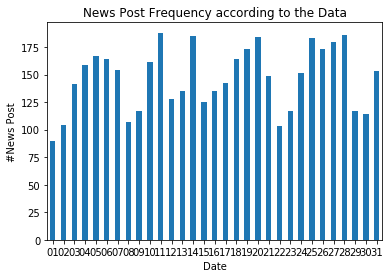

In [31]:
data_US_16_10_sorted['day'].value_counts().sort_index().plot.bar()
plt.title('News Post Frequency according to the Data')
plt.ylabel('#News Post')
plt.xlabel('Date')
plt.xticks(rotation=0)
plt.show()

##### 1.3 Load text of news

1.3.1 load the file

In [32]:
with open(txt_file, 'r') as f:
    txt = f.read()

In [33]:
# show the text content
txt[:1500]

'@@14637197 <p> NEW YORK ( AP ) -- Donald Trump \'s five-day feud with a former beauty queen is only the latest example of his insistence on airing and re-airing his grievances no matter the political cost . <p> The Republican nominee \'s brash , confrontational style has thrilled his millions of supporters , who have cheered the celebrity businessman \'s tenacity and thirst for verbal combat . He bragged in the early weeks of his campaign last year , " When people treat me unfairly , I do n\'t let them forget it . " <h> Subscription Required <p> An online service is needed to view this article in its entirety . You need an online service to view this article in its entirety . <p> Thank you for reading 15 free articles on our site . You can come back at the end of your 30-day period for another 15 free articles , or you can purchase a subscription and continue to enjoy valuable local news and information . If you need help , please contact our office at 276-669-2181 . You need an onlin

1.3.2 Data formalization and cleaning

In [34]:
# re object defination
# get ID
id_tag = re.compile('\@\@([0-9]{8})')

# remove <p>, <p>
tagger = re.compile(r'\<.{1,2}\>')

In [35]:
# generator of the id_tag
iterpnt = id_tag.finditer(txt)
txt_dict = {}

In [36]:
# get id regexp object list
pnt_list = [pnt for pnt in iterpnt]

# get the text responding to news id
for i in range(1, len(pnt_list)+1):
    if i < len(pnt_list):
        txt_dict[pnt_list[i-1].group(1)] = tagger.sub('', txt[pnt_list[i-1].span()[1]:pnt_list[i].span()[0]])
    else:
        txt_dict[pnt_list[i-1].group(1)] = tagger.sub('', txt[pnt_list[i-1].span()[1]:])

In [37]:
# transform to DataFrame
txt_pd = pd.DataFrame(pd.Series(txt_dict, name='txt'))
txt_pd.head(5)

,txt
14637197,NEW YORK ( AP ) -- Donald Trump 's five-day ...
14637200,Here 's all the crazy stuff that happened at...
14637201,Another hotel wants to build in the heart of...
14637202,"In this Sept. 23 , 2016 photo , Rick Wollum ..."
14637203,Court erases jury award of punitive damages ...


In [38]:
# show the transformed content of an article
txt_pd['txt'][0]

'  NEW YORK ( AP ) -- Donald Trump \'s five-day feud with a former beauty queen is only the latest example of his insistence on airing and re-airing his grievances no matter the political cost .  The Republican nominee \'s brash , confrontational style has thrilled his millions of supporters , who have cheered the celebrity businessman \'s tenacity and thirst for verbal combat . He bragged in the early weeks of his campaign last year , " When people treat me unfairly , I do n\'t let them forget it . "  Subscription Required  An online service is needed to view this article in its entirety . You need an online service to view this article in its entirety .  Thank you for reading 15 free articles on our site . You can come back at the end of your 30-day period for another 15 free articles , or you can purchase a subscription and continue to enjoy valuable local news and information . If you need help , please contact our office at 276-669-2181 . You need an online service to @ @ @ @ @ @ 

### Part 2: Select Topic

After data processing, we step to the next step of topic selection. We will use the methods of TF-IDF, which has been embeded in skicit-learn.

##### 2.1 Get the word frequency

In [39]:
# In the milestone, we only consider 1-gram in the tf-idf
countvec = CountVectorizer(stop_words='english', ngram_range=(1,1))
tfidfvec = TfidfTransformer()

In [40]:
text_list = list(stemming_list.values)
ind_list = list(stemming_list.keys())

In [41]:
# calculate the word frequency
word_freq = countvec.fit_transform(text_list)

In [42]:
# get the number of news and the number of 1-gram
num_doc, num_feat = word_freq.shape

In [43]:
# show 1-gram words sorted in alphabetical order
features = countvec.get_feature_names()
features[10000:10010]

['burke',
 'burkett',
 'burkhardt',
 'burkholder',
 'burkina',
 'burkitt',
 'burkle',
 'burks',
 'burlap',
 'burleigh']

In [44]:
# show the word frequency matrix
word_freq

<23055x65844 sparse matrix of type '<class 'numpy.int64'>'
	with 2365276 stored elements in Compressed Sparse Row format>

We find that the word freqency matrix is highly sparse.

In [45]:
# glance at the sparse matrix
pd.DataFrame(word_freq[0:10].toarray(), columns=countvec.get_feature_names())

,00,000,0000,000th,001,002,0023,003,004,005,...,zuzu,zverev,zvi,zweig,zwick,zwierlein,zwilling,zx,zygote,zz
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


###### 2.2 TF-IDF for topic selection

In [46]:
def get_keywords(matrix, features = None, n = 5):
    """
    Get top n keywords from the given CSR matrix
    Params: matrix: scipy.CSR
            features: list: e.g. the n-grams
            n: int
    Return: list(np.array)
    """
    
    results = []
    for start, end in zip(matrix.indptr[:-1], matrix.indptr[1:]):
        
        # Check whether there are at least n entries in this line
        select = min(n, end - start)
        
        # Get top select index of this row in sorted order
        select_indices = np.argsort(matrix.data[start: end])[-select:][::-1]
        
        # Get col index of the top features
        results.append(np.column_stack([matrix.indices[start + select_indices],
                                       matrix.data[start + select_indices]]))
        
    if features:
        
        # Add the features in if necessary
        results = list(list(map(lambda item: [features[int(item[0])], item[1]], 
                               news)) for news in results)
    return results

In [47]:
# from sparse word frequency, calculate the tf-idf matrix
tfidf = tfidfvec.fit_transform(word_freq)

In [48]:
# get the entries with value in the sparse matrix
entries = tfidf.tolil().rows

In [49]:
len(features)

65844

In [50]:
# show the keywords of the first docoment
pd.DataFrame(features).iloc[entries[0]].head(10)

,0
359,15
1109,30
3354,airing
4627,ap
5203,article
7081,beauty
9095,brag
9179,brash
10092,businessman
10499,campaign


In [ ]:
# record the keyword index for each document
tfidf_matrix = [[(entries[doc][i], tfidf[doc].toarray()[0][entries[doc][i]]) for i in range(len(entries[doc]))] for doc in range(num_doc)]

In [ ]:
# save the matrix to pickle
with open('tfidf.pickle', 'wb') as f:
    pickle.dump(tfidf_matrix, f)

In [51]:
# load the pickle to tfidf-matrix
with open('tfidf.pickle', 'rb') as w:
    tfidf_matrix = pickle.load(w)

In [52]:
tfidf_top10 = [sorted(tfidf_matrix[i], key=lambda x: x[1], reverse=True)[:10] for i in range(num_doc)]
tfidf_top10_name = [[(features[x[0]], x[1]) for x in tfidf_top10[i]] for i in range(num_doc)]
tfidf_top10_pd = pd.DataFrame(tfidf_top10_name, index=ind_list)
tfidf_top10_pd.index.name = 'Id'
tfidf_top10_Nameset = [x[0] for i in range(num_doc) for x in tfidf_top10_name[i]]
tfidf_top10_key = [[x[0] for x in tfidf_top10_name[i]] for i in range(num_doc)]

In [53]:
tfidf_top20 = [sorted(tfidf_matrix[i], key=lambda x: x[1], reverse=True)[:20] for i in range(num_doc)]
tfidf_top20_name = [[(features[x[0]], x[1]) for x in tfidf_top20[i]] for i in range(num_doc)]
tfidf_top20_pd = pd.DataFrame(tfidf_top20_name, index=ind_list)
tfidf_top20_pd.index.name = 'Id'
tfidf_top20_Nameset = [x[0] for i in range(num_doc) for x in tfidf_top20_name[i]]
tfidf_top20_key = [[x[0] for x in tfidf_top20_name[i]] for i in range(num_doc)]

In [54]:
# choose top 5 as the keywords of the news
tfidf_top5 = [sorted(tfidf_matrix[i], key=lambda x: x[1], reverse=True)[:5] for i in range(num_doc)]

In [55]:
tfidf_top5_name = [[(features[x[0]], x[1]) for x in tfidf_top5[i]] for i in range(num_doc)]

In [56]:
# convert to pandas DataFrame
tfidf_top5_pd = pd.DataFrame(tfidf_top5_name, index=ind_list)
tfidf_top5_pd.index.name = 'Id'

In [57]:
# show the tfidf
tfidf_top5_pd.head()

,0,1,2,3,4
Id,,,,,
14637197,"(article, 0.3231129513690259)","(entirety, 0.2510290164608949)","(online, 0.24465264706847722)","(need, 0.2234580095033969)","(subscription, 0.2170400061690015)"
14637200,"(toledo, 0.5006275298991661)","(byu, 0.2251267442257118)","(mack, 0.20236457207395567)","(woodside, 0.1817846776596635)","(game, 0.1708867364649886)"
14637201,"(cahuenga, 0.3443785000085918)","(hollywood, 0.3316018473377978)","(hotel, 0.24975932711993432)","(project, 0.19498070640999493)","(parking, 0.18095834624622986)"
14637202,"(river, 0.43741932617450596)","(whitefish, 0.41041669203250136)","(yellowstone, 0.35392258902672885)","(fish, 0.28701407869412077)","(biologist, 0.19724807594786847)"
14637203,"(punitive, 0.3455224429347211)","(newsgathering, 0.2737209523650647)","(motorcyclist, 0.2466180682188501)","(claim, 0.22002071797655545)","(erase, 0.2046431001293423)"


In [58]:
# get the all repeated keywords
tfidf_top5_Nameset = [x[0] for i in range(num_doc) for x in tfidf_top5_name[i]]

In [59]:
# get the keyword list for each documents
tfidf_top5_key = [[x[0] for x in tfidf_top5_name[i]] for i in range(num_doc)]

##### 2.3 Topic Selection

In [60]:
# get the frequency of each keywords
cnt = Counter(tfidf_top5_Nameset)

In [61]:
# switch the frequency dictionary to DataFrame
key_words_pd = pd.DataFrame(pd.Series(dict(cnt)), columns=['Frequency'])

In [62]:
# select the top 20 highly-frequent keywords
key_words_top20 = key_words_pd.sort_values(by='Frequency', ascending=False).iloc[:20]
key_words_top20.index.name = 'Keywords'

In [63]:
# show top 20 frequent keywords
key_words_top20.head()

,Frequency
Keywords,
trump,994
clinton,453
game,432
police,396
say,274


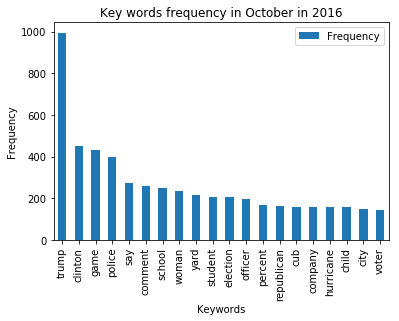

In [64]:
# plot the bar chart to illustrate the top-20 keywords
key_words_top20.plot(kind='bar')
plt.title('Key words frequency in October in 2016')
plt.ylabel('Frequency')
plt.xlabel('Keywords')
plt.show()

### Discovery:
After our tfidf analysis, we could find out that in the month rightly before American Precidental Election held on 8th November 2016, many pieces of news are highly related to the presidential election.

Later, we chose 'trump' as the selected topic to further dig up the media polarity considering time variance.

In [64]:
# get the news id whose keywords contains 'trump'
trump_list = [ind_list[i] for i in range(num_doc) if 'trump' in tfidf_top5_key[i]]

In [61]:
# save the news list in pickle
with open('trump_list.pickle', 'wb') as w:
    pickle.dump(trump_list, w)

### Part3: Get Original Data from Website

Considering some missing original text in our data, we further applied the methodology of web crawling from the websites provided in our dataset. We will developed more application this part in the future.

In [71]:
# remove the extra space and tag (such as <p>) in the raw text
tags_re = re.compile(r'(\<.*\>|\s+)')

In [57]:
def HTMLGetandParser(url):
    """
        Aimed to get the information based URL, and parse and select the data according to HTML
        input: url
        output: txt
    """
    r = requests.get(url)
    soup = BeautifulSoup(r.text, 'html.parser')
    paragraph = soup.p
    txt = ''
    
    while paragraph:
        txt += (tags_re.sub(' ', str(paragraph)) if len(str(paragraph)) > 100 else '')
        paragraph = paragraph.next
    return txt

In [ ]:
web_pd = data_US_16_10_sorted.iloc[:100]['website'].apply(lambda url: HTMLGetandParser(url))

In [ ]:
# show web pd
web_pd.head()

### Part4: Conduct Sentimental Analysis

##### 4.1 Helper functions

In [65]:
def sentiment_TextBlob(text,pos_threshold = 0.3,neg_threshold = -0.3):
    """
    Get polarity of text by mean of polarity of each sentence
    Since most sentences convey nothing in an article, we decide to eliminate neutral sentence
    and only take polar sentence into account
    If there is no polar sentence in an article, return 0
    Params: text: str
            pos_threshold: float
            neg_threshold: float
    """
    # Get blob
    blob = TextBlob(text)
    
    # Get sentence objs
    sentences = blob.sentences
    
    # Get sentence polarity
    polarity = list(map(lambda x: 1 if x.sentiment[0] > pos_threshold \
                                    else (-1 if x.sentiment[0] < neg_threshold \
                                             else 0),
                      sentences))
    
    # Calculate article polarity
    polarity = np.array(polarity)
    if np.all(np.unique(polarity) == 0):
        return 0
    
    return np.sum(polarity) / np.sum(polarity != 0)

In [66]:
def sentiment_nltk(text,pos_threshold = 0.3,neg_threshold = -0.3):
    '''
    Get polarity of article using nltk
    Params: text: str
            pos_threshold: float
            neg_threshold: float
    Return: polarity
    '''
    
    # Get sentences
    sentences=nltk.sent_tokenize(text)
    
    # Get polarity analyzer
    sid = SentimentIntensityAnalyzer()

    # Calculate scores and polarity of sentences
    scores = list(map(lambda x: sid.polarity_scores(x)['compound'], sentences))
    polarity = list(map(lambda x: 1 if x > pos_threshold \
                                       else (-1 if x < neg_threshold \
                                            else 0),
                       scores))

    # Calculate article polarity
    polarity = np.array(polarity)
    if np.all(np.unique(polarity) == [0]):
        return 0
    
    return np.sum(polarity) / np.sum(polarity != 0)

In [67]:
def find_polarity_tags(articles):
    '''
    Return polarity for articles using mean of nltk and textblob
    Params: articles: Array(str)
    Return: tags
    '''
    
    polarity_articles = list(map(lambda x: np.mean([sentiment_TextBlob(x),
                                                   sentiment_nltk(x)]),
                               articles))
    
    return polarity_articles


##### 4.2 Explore on Media Polarity about 'trump' on October 2016

In [86]:
# Obtain list of index of news with keyword Trump
Trump_list=pd.read_pickle('trump_list.pickle')

In [87]:
# Obtain dataframe of news with keyword Trump
mask = data_US_16_10['id'].isin(Trump_list)
data_Trump = data_US_16_10_sorted.loc[mask]

In [88]:
# Obtain dataframe of news for top30 medias
mask = data_Trump['media'].isin(US_top_30_media)
data_Trump = data_Trump.loc[mask]

In [89]:
data_Trump.to_csv('data_trump.csv')

In [90]:
# Convert index of txt_pd to int type
txt_pd.index = txt_pd.index.astype(int)

In [91]:
# Get news focus on Trump by merging the related ids with news df
Trump_news_16_10 = data_Trump.merge(txt_pd, left_on='id', right_index = True)

In [92]:
# Show the news focused on Trump
Trump_news_16_10.head()

,id,unknown,date,country,media,website,title,year,month,day,txt
305321,14651155,1115,16-10-02,US,Los Angeles Times,http://www.latimes.com/politics/la-pol-ca-toba...,Why opponents of increasing the tobacco tax ar...,16,10,02,"On election day , voters will decide whether..."
305348,14651190,154,16-10-02,US,NBC News,http://www.cnbc.com/2016/10/02/donald-trumps-t...,Trump's Long History of Tweet-Shaming on Taxes,16,10,02,Trump 's Long History of Tweet-Shaming on Ta...
305700,14655253,279,16-10-02,US,Politico,http://www.politico.com/story/2016/10/bernie-s...,Sanders: Trump tax bombshell is evidence of in...,16,10,02,Sanders : Trump tax bombshell is evidence of...
305728,14655767,563,16-10-02,US,ABC News,http://abcnews.go.com/Politics/note-surrogates...,The Note: Surrogates Spin NYT Tax Story as Pro...,16,10,02,--RUDY GIULIANI SAYS TRUMP 'S CLAIM OF $916 ...
305733,14655772,537,16-10-02,US,NBC News,http://www.nbcnews.com/politics/2016-election/...,"Christie, Giuliani: Trump's Manipulation of Ta...",16,10,02,Donald Trump 's allies argued Sunday that a ...


In [93]:
# Find polarity of news 
Trump_news_16_10['polarity'] = find_polarity_tags(Trump_news_16_10['txt'])

In [94]:
# Check the correctness of polarity tags
news_for_check = Trump_news_16_10.copy()
news_for_check = news_for_check.reset_index()
news_for_check

,index,id,unknown,date,country,media,website,title,year,month,day,txt,polarity
0,305321,14651155,1115,16-10-02,US,Los Angeles Times,http://www.latimes.com/politics/la-pol-ca-toba...,Why opponents of increasing the tobacco tax ar...,16,10,02,"On election day , voters will decide whether...",0.416667
1,305348,14651190,154,16-10-02,US,NBC News,http://www.cnbc.com/2016/10/02/donald-trumps-t...,Trump's Long History of Tweet-Shaming on Taxes,16,10,02,Trump 's Long History of Tweet-Shaming on Ta...,0.666667
2,305700,14655253,279,16-10-02,US,Politico,http://www.politico.com/story/2016/10/bernie-s...,Sanders: Trump tax bombshell is evidence of in...,16,10,02,Sanders : Trump tax bombshell is evidence of...,0.400000
3,305728,14655767,563,16-10-02,US,ABC News,http://abcnews.go.com/Politics/note-surrogates...,The Note: Surrogates Spin NYT Tax Story as Pro...,16,10,02,--RUDY GIULIANI SAYS TRUMP 'S CLAIM OF $916 ...,0.454545
4,305733,14655772,537,16-10-02,US,NBC News,http://www.nbcnews.com/politics/2016-election/...,"Christie, Giuliani: Trump's Manipulation of Ta...",16,10,02,Donald Trump 's allies argued Sunday that a ...,0.305556
5,305745,14655792,232,16-10-02,US,Politico,http://www.politico.com/story/2016/10/nyt-repo...,NYT reporters defend legality of Trump tax report,16,10,02,NYT reporters defend legality of Trump tax r...,0.333333
6,305842,14657711,641,16-10-02,US,ABC News,http://abcnews.go.com/Politics/years-tax-retur...,Four Years of Tax Returns All Show Donald Trum...,16,10,02,Although GOP presidential nominee Donald Tru...,0.555556
7,305133,14658917,774,16-10-02,US,Washington Post,https://www.washingtonpost.com/news/wonk/wp/20...,The most shocking part of Donald Trump's tax r...,16,10,02,The major takeaway from the three pages of T...,0.301587
8,305572,14662893,648,16-10-02,US,New York Post,http://nypost.com/2016/10/02/the-idiocy-of-cal...,The idiocy of calling Donald Trump a 'bully',16,10,02,Either Democrats and the national media know...,-0.388889
9,306010,14668074,2081,16-10-03,US,Politico,http://www.politico.com/story/2016/10/michael-...,What SNL's weekend anchors really think of 2016,16,10,03,"Michael Che and Colin Jost of "" Saturday Nig...",0.287931


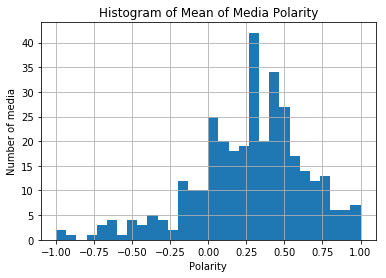

In [95]:
# Visualize the polarity
Trump_news_16_10['polarity'].hist(bins=30, grid=True)
plt.title('Histogram of Mean of Media Polarity')
plt.xlabel('Polarity')
plt.ylabel('Number of media')
plt.show()

In [96]:
# collect polarity of news from same media
Trump_media = Trump_news_16_10.groupby('media')['polarity'].apply(np.array)

In [97]:
Trump_media

media
ABC News             [0.45454545454545453, 0.5555555555555556, 0.75...
CBS News             [-0.6666666666666666, 0.3, 0.5, 0.25, 0.051282...
CNN                  [0.3181818181818182, 0.9, 0.2962962962962963, ...
Daily Beast                                                      [0.0]
Fox News             [0.6923076923076923, 0.5555555555555556, -0.63...
Huffington Post      [0.0, 0.3277310924369748, 0.29166666666666663,...
Los Angeles Times    [0.41666666666666663, 0.5, -0.1666666666666666...
NBC News             [0.6666666666666666, 0.3055555555555556, 0.270...
NPR                  [0.4, 0.6892307692307692, 0.2857142857142857, ...
New York Post        [-0.3888888888888889, 0.33333333333333337, 1.0...
Politico             [0.4, 0.33333333333333337, 0.2879310344827586,...
Quartz               [0.4483870967741936, 0.56, 0.2777777777777778,...
Slate Magazine       [0.3581395348837209, -0.5, 0.75, 0.04395604395...
TIME                 [0.07309941520467836, 0.28787878787878785, 0.5...


It is not representative to investigate into the media that have few pieces of news about Trump. By trial and error we select 12 as a threshold for selecting representative media.

In [98]:
Trump_media = Trump_media.to_frame()

Trump_media_top = Trump_media[Trump_media['polarity'].apply(lambda x: len(x)) > 12].copy()

Considering there exists the offset during sentimental analysis, we decided to normalize the data (subtract the mean of all of the polarities) in order to have a better understanding on our dataset.

In [99]:
# Get universal mean of polarity of representative news
media_count = Trump_media_top['polarity'].apply(len)

media_mean = Trump_media_top['polarity'].apply(np.mean)

mean_polarity = np.sum(media_count * media_mean) / np.sum(media_count)

In [100]:
# Normalize the polarity
Trump_media_top['normalized_polarity'] = Trump_media_top['polarity'] - mean_polarity

In [109]:
Trump_media_top.to_csv('Trump_media_top.csv')

In [99]:
Trump_media_top.head(3)

,polarity,normalized_polarity,tags
media,,,
ABC News,"[0.45454545454545453, 0.5555555555555556, 0.75...","[0.18329929872149886, 0.2843093997315999, 0.47...","[0.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 0.0, -1...."
CBS News,"[-0.6666666666666666, 0.3, 0.5, 0.25, 0.051282...","[-0.9379128224906224, 0.02875384417604432, 0.2...","[-1.0, 0.0, 1.0, 0.0, -1.0, 1.0, -1.0, -1.0, -..."
CNN,"[0.3181818181818182, 0.9, 0.2962962962962963, ...","[0.046935662357862507, 0.6287538441760443, 0.0...","[0.0, 1.0, 0.0, -1.0, 0.0, 0.0, 1.0, 0.0, -1.0..."


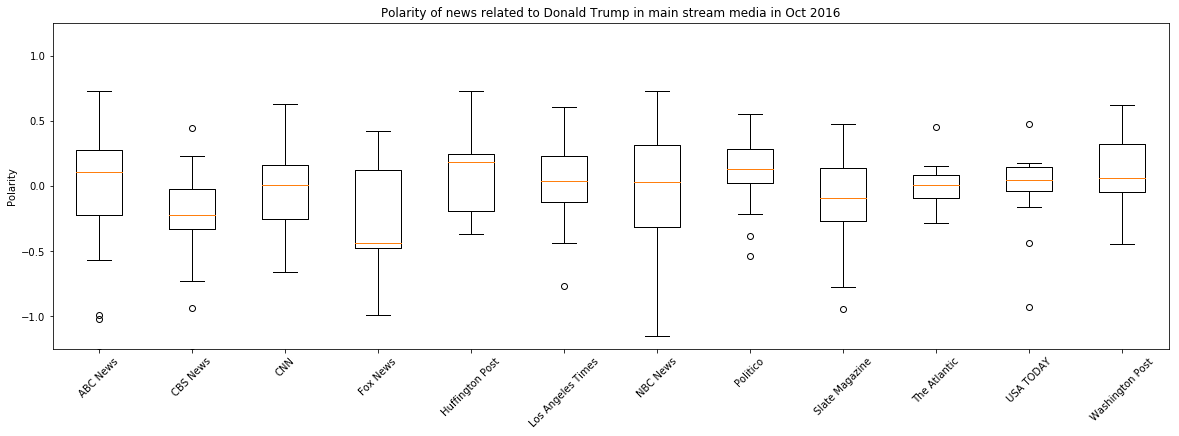

In [102]:
# Visualize the polarity of media
data = Trump_media_top['normalized_polarity'].values

index = Trump_media_top.index

plt.rcParams['figure.figsize'] = (20, 6)
plt.boxplot(list(data))
plt.xticks(np.arange(len(index)) + 1, index, rotation=45)
plt.ylim(-1.25, 1.25)
plt.ylabel('Polarity')
plt.title('Polarity of news related to Donald Trump in main stream media in Oct 2016')
plt.show()

In [103]:
# Store data for further usage
Trump_news_16_10.to_pickle('Trump_news_16_10_polar.pickle')

##### 4.3 Explore the time variance of media polarity

By repeating the same manipulation scheme, we obtain the data for Aug and Sept of 2016. For simplicity, here we just load those data in and conduct analysis. The functionalities will be finely encapusulated in the next step to provide better scalability.

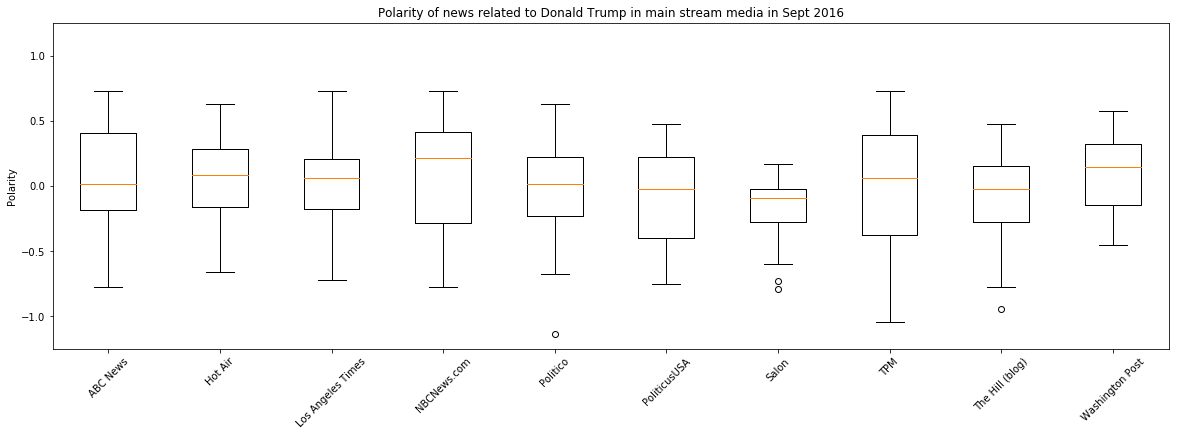

In [104]:
# Comparisons
Trump_media_top_sept = pd.read_pickle('Trump_media_top_Sept.pkl')

# Visualize the polarity of media in Sept
data = Trump_media_top_sept['normalized_polarity'].values

index = Trump_media_top_sept.index

plt.rcParams['figure.figsize'] = (20, 6)
plt.boxplot(list(data))
plt.xticks(np.arange(len(index)) + 1, index, rotation=45)
plt.ylim(-1.25, 1.25)
plt.ylabel('Polarity')
plt.title('Polarity of news related to Donald Trump in main stream media in Sept 2016')
plt.show()

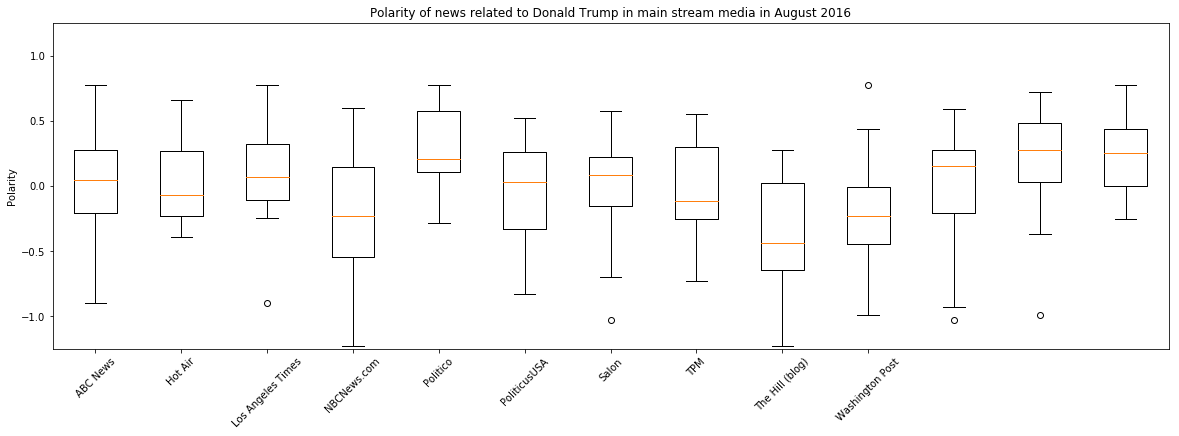

In [105]:
# Comparisons
Trump_media_top_aug = pd.read_pickle('Trump_media_top_Aug.pkl')

# Visualize the polarity of media in August
data = Trump_media_top_aug['normalized_polarity'].values

index = Trump_media_top_sept.index

plt.rcParams['figure.figsize'] = (20, 6)
plt.boxplot(list(data))
plt.xticks(np.arange(len(index)) + 1, index, rotation=45)
plt.ylim(-1.25, 1.25)
plt.ylabel('Polarity')
plt.title('Polarity of news related to Donald Trump in main stream media in August 2016')
plt.show()

In [106]:
# Visualize the attitude change of media during three months

media_intersection = set(Trump_media_top.index)\
                        .intersection(set(Trump_media_top_sept.index))\
                        .intersection(set(Trump_media_top_aug.index))

Media that are continuosly interested in Trump over three months

In [81]:
media_intersection = pd.DataFrame(list(media_intersection))

In [82]:
media_intersection.columns = ['media']

In [83]:
# show median_intersection
media_intersection

,media
0,ABC News
1,Politico
2,PoliticusUSA
3,Washington Post
4,NBCNews.com
5,TPM
6,Los Angeles Times


In [84]:
# Get the normalized polarity of media in intersection
media_intersection_polarity = media_intersection.merge(Trump_media_top, left_on = 'media', right_index = True)\
                                                .merge(Trump_media_top_sept, left_on = 'media', right_index = True,
                                                      suffixes = ('_Oct', '_Sept'))\
                                                .merge(Trump_media_top_aug, left_on = 'media', right_index = True)

In [85]:
# rename the columns to meaningful name
media_intersection_polarity.rename(columns = dict(polarity = 'polarity_Aug',
                                             normalized_polarity = 'normalized_polarity_Aug'), inplace = True)
media_intersection_polarity.set_index(keys = ['media'], inplace = True)

In [86]:
# show the media polarity
media_intersection_polarity

,polarity_Oct,normalized_polarity_Oct,normalized_polarity_Sept,polarity_Sept,normalized_polarity_Aug,polarity_Aug
media,,,,,,
ABC News,"[0.45454545454545453, 0.5555555555555556, 0.75...","[0.19004690338244645, 0.2910570043925475, 0.48...","[-0.5665424574417921, 0.30845754255820784, 0.0...","[-0.29166666666666663, 0.5833333333333334, 0.3...","[0.2727541538606477, 0.12275415386064772, -0.5...","[0.5, 0.35, -0.3333333333333333, 0.03333333333..."
Politico,"[0.4, 0.33333333333333337, 0.2879310344827586,...","[0.13550144883699194, 0.06883478217032529, 0.0...","[-0.5248757907751256, 0.10973959384025905, 0.6...","[-0.25, 0.3846153846153846, 0.9, 0.57142857142...","[0.22355506919245552, 0.028114777642324146, -0...","[0.45080091533180777, 0.2553606237816764, -0.1..."
PoliticusUSA,"[-0.26666666666666666, -0.1, 0.504273504273504...","[-0.5311652178296747, -0.3644985511630081, 0.2...","[-0.5748757907751255, -0.024875790775125528, 0...","[-0.3, 0.25, 0.5, 0.22916666666666666, -0.4747...","[0.487039868146362, -0.11613473502824115, -0.2...","[0.7142857142857143, 0.1111111111111111, -0.07..."
Washington Post,"[0.3015873015873016, 0.3802008608321377, 0.625...","[0.03708875042429355, 0.11570230966912964, 0.3...","[-0.2034472193465541, -0.12580746779375906, -0...","[0.07142857142857142, 0.14906832298136646, 0.2...","[-0.18538538102307317, -0.0017023678784826857,...","[0.041860465116279076, 0.22554347826086957, 0...."
NBCNews.com,"[0.3055555555555556, 0.27058823529411763, 0.13...","[0.0410570043925475, 0.006089684131109552, -0....","[0.46512420922487446, 0.30845754255820784, -0....","[0.74, 0.5833333333333334, 0.10666666666666666...","[-0.26724584613935226, 0.07527516226400907, -0...","[-0.04000000000000001, 0.3025210084033613, -0...."
TPM,"[-0.7142857142857143, -0.30952380952380953, 0....","[-0.9787842654487224, -0.5740223606868176, 0.2...","[-0.37487579077512556, 0.7251242092248744, 0.5...","[-0.1, 1.0, 0.8571428571428572, 0.666666666666...","[0.17275415386064777, 0.022754153860647747, -0...","[0.4, 0.25, -0.20833333333333334, -0.166666666..."
Los Angeles Times,"[0.41666666666666663, 0.5, -0.1666666666666666...","[0.15216811550365855, 0.23550144883699192, -0....","[-0.17487579077512552, 0.18666267076333604, 0....","[0.1, 0.46153846153846156, 0.5608465608465608,...","[-0.07605221218709762, 0.3609894479782948, -0....","[0.15119363395225463, 0.5882352941176471, 0.10..."


In [87]:
# Find mean for each cell
media_intersection_polarity = media_intersection_polarity.applymap(np.mean)

In [88]:
# show polarity after mean calculation
media_intersection_polarity

,polarity_Oct,normalized_polarity_Oct,normalized_polarity_Sept,polarity_Sept,normalized_polarity_Aug,polarity_Aug
media,,,,,,
ABC News,0.257565,-0.006934,0.038081,0.312957,-0.000394,0.226852
Politico,0.400635,0.136136,-0.055315,0.219560,-0.019178,0.208068
PoliticusUSA,0.136290,-0.128208,-0.077470,0.197406,-0.003161,0.224085
Washington Post,0.379463,0.114964,0.103932,0.378808,0.219542,0.446787
NBCNews.com,0.219658,-0.044840,0.076774,0.351650,-0.081730,0.145515
TPM,0.127434,-0.137065,-0.009872,0.265004,-0.215731,0.011515
Los Angeles Times,0.310189,0.045690,-0.016708,0.258168,0.080395,0.307641


In [89]:
# clean the dataframe and drop the useless columns
media_intersection_polarity.drop(labels = ['polarity_Oct', 'polarity_Sept', 'polarity_Aug'],
                                 axis = 1,
                                 inplace = True)

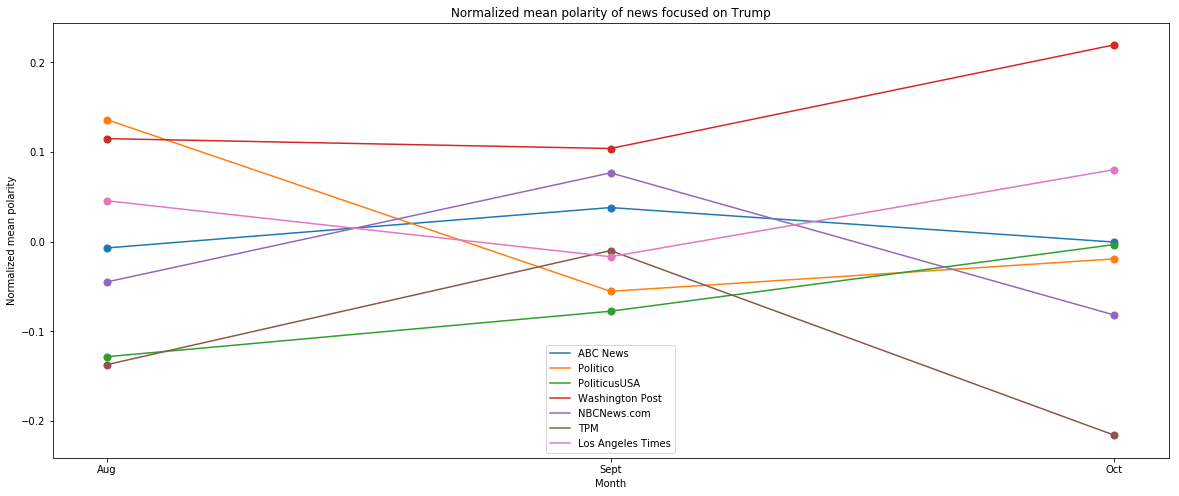

In [90]:
# plot the polarity of popular medias based on the topic of 'trump' in August, September, October 2016
keys = ['normalized_polarity_Aug', 'normalized_polarity_Sept', 'normalized_polarity_Oct']
medias = media_intersection_polarity.index
plt.rcParams['figure.figsize'] = (20, 8)
for media in medias:
    plt.scatter(x = np.arange(len(keys)),
               y = media_intersection_polarity.loc[media],
               s = 50)
    plt.plot(np.arange(len(keys)),
            media_intersection_polarity.loc[media])
plt.legend(medias, loc = 'best')
plt.xticks(np.arange(len(keys)), ['Aug', 'Sept', 'Oct'])
plt.xlabel('Month')
plt.ylabel('Normalized mean polarity')
plt.title('Normalized mean polarity of news focused on Trump')
plt.show()

## MileStone2 Conclusion:
During this milestone, we collected and preprocessed the data, tried our proposed methods on test part, got some progressive development, and obtained some inspiration from the difficulties. We firstly focused on media reaction on the topic of trump in October 2016, and extended to time domain, as proposed in milestone. Basically speaking, referring to some controversial topics, there indeed exists media porlarity, based on our three-month US news analysis before 2016 presidental election. We would like to go further till the next milestone.

In the following, we show some difficulties we met during this milestone, and some expectation of milestone3.

## MileStone3 Guideline:

### Motification of MileStone2:
- In the part one data preprocessing, we added some grouping and combination of medias, as we find that one media could be multiple names in our dataset.
- As found in the milestone2, there is a lot of noises on time, therefore, we quitted the study of time variation, and mainly focus on the October.
- As suggested by Dr. Periklis Chrysogelos, the noise in the sentimental analysis is difficult to deal with, therefore, we switched our method from quantitative to qualitative.



### Agenda
In this final milestone, we implement several parts:
- Part5: Revisit to media polarity about Trump. And we will select some medias with obvious features as our main targets.
- Part6: we will expand the topics from the keyword set we have got, and select the interesting ones which are perhaps related to the election.
- Part7: we study these topics just like what we have done in part5
- Part8: based on the results of part5 and part7, we try to find out the correlation for a specific media to trump and the relative topics.
- Conclusion

### Part 5: Modify methodolodies in Milestone2
#### Brief Introduction:
As mentioned above, after analyzing the result of milestone2, we find out the quantitative result can not distinguish the media polarity very much. And the time variation is not very obvious. Therefore, in this part, we will use the qualitative methods to revisit the last part of milestone2.

##### 5.1 Find the best threshold

As what we have done in Milestone2, we have implemented a function to return the sentimental score of the passage based on the combinational result of NLTK and TextBlob. This score is ranging from -1 to 1 continuously, therefore, it is important for us to find the threshold and classify the passage to three classes which are 'positive', 'negative', and 'neural'.

we randomly choose 50 news about Trump, and we three team members manually read and labelled with -1(negative), 0(neutral), and 1(positive).

In [109]:
# get the trump text list
trump_txt = txt_pd.loc[[i for i in Trump_list]]
trump_txt_list = list(trump_txt['txt'])

In [113]:
# generate the random documents as validation set
num_trump_txt = len(trump_txt_list)
random_select = np.random.permutation(num_trump_txt)[:50]

In [114]:
for idx in range(len(random_select)):
    with open('Reference/text%d.txt'%(idx+1), 'w') as w:
        w.write(trump_txt_list(random_select[idx]))

In [115]:
validation_set = [trump_txt_list[idx] for idx in random_select]

In [117]:
# read our label result in
validationLabel = pd.read_csv('validation.csv', header=0)
validationLabelList = list(validationLabel['Unnamed: 0'])

In [122]:
def find_polarity_tags(articles):
    '''
    Get polarity for articles using mean of nltk and textblob
    Params: articles: Array(str)
    Return: tags
    '''
    
    polarity_articles = list(map(lambda x: np.mean([sentiment_TextBlob(x),
                                                   sentiment_nltk(x)]),
                               articles))
    
    return polarity_articles

In [293]:
# define accuracy function
def checkAccuracy(modelout, validationList):
    """
    This function is used to check the accuracy referring to our labelled txt
    Check accuracy of predicted labels of txt
    Params: modelout: model
            validationList: list
    Return: float
    """

    accuracy = sum([1 if validationList[i] == select_score_normal[i] \
                    else 0 for i in range(len(validationList))]) / len(validationList)
    return accuracy

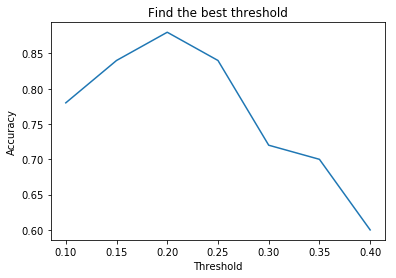

In [124]:
# Validation to find the threshold
thresholdList = [0.1, 0.15, 0.2, 0.25 ,0.3, 0.35, 0.4]
accuracyList = []
for i in range(len(thresholdList)):
    select_score = find_polarity_tags(validationLabel)
    select_score_normal = [1 if val > thresholdList[i] else \
                           (0 if val > -thresholdList[i] else -1) \
                           for val in select_score]
    accuracyList.append(checkAccuracy(select_score_normal))

plt.plot(thresholdList, accuracyList)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Find the best threshold')
plt.show()

From our validation in 50 samples, we find the best threshold is about 0.2. Therefore, in the following , we set threshold to be 0.2

We randomly pich an article and check the polarity score.

In [363]:
news_for_check['polarity'][337]

0.4285714285714286

In [364]:
news_for_check['txt'][337]

'  But in Colorado the candidate \'s own words , perhaps unintentionally , could be construed as calling for voter fraud .  Colorado voters automatically get mail-in ballots . " Do you think those ballots are properly counted ? " Trump asked the audience at a rally in Greeley on Sunday night . " I know they are saying , \' Oh , of course , it \'s all legitimate . \' Perhaps I \'m a more skeptical person . "  He urged supporters to get a " new ballot " at their polling locations .  " They \'ll give you a ballot , a new ballot . They \'ll void your old ballot , they will give you a new ballot . And you can go out and make sure it gets in , " Trump said .  In fact , voters are only allowed to request a new ballot if they have not yet submitted their mail-in ballots , according to Colorado officials . Trump does n\'t appear to be calling for both votes to be counted , but it does n\'t @ @ @ @ @ @ @ @ @ @ changed once it has been submitted .  Trump added , somewhat cryptically : " In some p

This article is positive because the score is larger than the threshold 0.2. And it is also tagged as "positive" manually so our classification and the real tag matches.

##### 5.2 From Quantitative study to Qualitative study

In [210]:
def tag_articles(polarity_list_origin, pos_threshold, neg_threshold):
    '''
    add polarity tags for articles
    Params: polarity_list_origin: list (a list of polarity score, which is in the column 'polarity' or 'normalized_polarity' in the dataframe)
            pos_threshold: float
            neg_threshold: float
    Return: polarity_list: list (a list of tags based on the polarity. The range of values is [0, 1, -1])
    '''
    
    polarity_list = polarity_list_origin.copy()
    
    for i in range(len(polarity_list)):
        if polarity_list[i] > pos_threshold:
            polarity_list[i] = int(1)
        elif polarity_list[i] < neg_threshold:
            polarity_list[i] = int(-1)
        else:
            polarity_list[i] = int(0)
            
    return polarity_list

In [211]:
def tag_proportion(tag_list):
    '''
    calculate the proportion for positive, negative and neutral tags for each list
    Params: tag_list: list
    Return: pos: float
            neu: float
            neg: float
    '''
    
    # Get length of list
    count = len(tag_list)
    
    # Get positive ratio
    pos = np.sum(tag_list == 1) / count
    
    # Get negative ratio
    neg = np.sum(tag_list == -1) / count
    
    # Get neutral ratio
    neu = 1 - pos - neg
    
    return pos, neu, neg

In [127]:
# Get postive, negative and neutral ratio for each media

Trump_media_top['tags'] = Trump_media_top['normalized_polarity'].copy(deep=True)
Trump_media_top['tags'] = Trump_media_top['tags'].apply(lambda x: tag_articles(x, 0.2, -0.2))

Trump_media_top['pos'] = Trump_media_top['tags'].apply(lambda x: tag_proportion(x)[0])
Trump_media_top['neu'] = Trump_media_top['tags'].apply(lambda x: tag_proportion(x)[1])
Trump_media_top['neg'] = Trump_media_top['tags'].apply(lambda x: tag_proportion(x)[2])

# Backup
Trump_media_top.to_csv('trump_media_top30_1610.csv')

In [128]:
Trump_media_top.head

,polarity,normalized_polarity,tags,pos,neu,neg
media,,,,,,
ABC News,"[0.45454545454545453, 0.5555555555555556, 0.75...","[0.18329929872149886, 0.2843093997315999, 0.47...","[0.0, 1.0, 1.0, -1.0, -1.0, 1.0, 1.0, 0.0, -1....",0.388889,0.305556,0.305556
CBS News,"[-0.6666666666666666, 0.3, 0.5, 0.25, 0.051282...","[-0.9379128224906224, 0.02875384417604432, 0.2...","[-1.0, 0.0, 1.0, 0.0, -1.0, 1.0, -1.0, -1.0, -...",0.117647,0.294118,0.588235
CNN,"[0.3181818181818182, 0.9, 0.2962962962962963, ...","[0.046935662357862507, 0.6287538441760443, 0.0...","[0.0, 1.0, 0.0, -1.0, 0.0, 0.0, 1.0, 0.0, -1.0...",0.210526,0.473684,0.315789
Fox News,"[0.6923076923076923, 0.5555555555555556, -0.63...","[0.4210615364837366, 0.2843093997315999, -0.90...","[1.0, 1.0, -1.0, -1.0, 0.0, -1.0, 1.0, 0.0, -1...",0.210526,0.210526,0.578947
Huffington Post,"[0.0, 0.3277310924369748, 0.29166666666666663,...","[-0.27124615582395567, 0.05648493661301912, 0....","[-1.0, 0.0, 0.0, 1.0, 0.0, 1.0, -1.0, -1.0, 0....",0.450000,0.300000,0.250000
Los Angeles Times,"[0.41666666666666663, 0.5, -0.1666666666666666...","[0.14542051084271096, 0.22875384417604433, -0....","[0.0, 1.0, -1.0, 0.0, 0.0, -1.0, 1.0, 1.0, -1....",0.297297,0.540541,0.162162
NBC News,"[0.6666666666666666, 0.3055555555555556, 0.270...","[0.39542051084271096, 0.03430939973159991, -0....","[1.0, 0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 1.0,...",0.341463,0.365854,0.292683
Politico,"[0.4, 0.33333333333333337, 0.2879310344827586,...","[0.12875384417604435, 0.0620871775093777, 0.01...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, ...",0.322581,0.580645,0.096774
Slate Magazine,"[0.3581395348837209, -0.5, 0.75, 0.04395604395...","[0.08689337905976524, -0.7712461558239556, 0.4...","[0.0, -1.0, 1.0, -1.0, -1.0, -1.0, 0.0, 1.0, 0...",0.222222,0.333333,0.444444


### Part6: Topic Expansion
#### Brief Introduction
In the keyword selection part, we have found that Trump is the most popular topic using TF-IDF. After that we obtained the polarity distributions the pieces of news related to Trump among various media.

In part5, we enlarge our range of topics. Specifically, we mainly focus on the topics which are related to Trump and investigate into their polarity distribution.

We use three methods to search the key words:
- Simple Frequency Check
- Cosine Similarity Check
- LDA Model Topic Selection

Due to the time limit, only the Cosine Similarity Check method is fully investigated. However, one can convince himself / herself that the other two methods will actually have the same performance.

And we select some interesting topics related to trump by utilizing above three methods together.

In [130]:
from PIL import Image
trump_coloring = np.array(Image.open("trumpface3.png"))

In [132]:
# Pre-load of module
from gensim.corpora import Dictionary
# initialize the wordcloud generater
wc = wordcloud.WordCloud(mask=trump_coloring, background_color="rgba(255, 255, 255, 0)", mode="RGBA")
# wc = wordcloud.WordCloud()
# wc = wordcloud.WordCloud(mask=trump_coloring)
# NLTK stemmer
ps = nltk.stem.PorterStemmer()
ls = nltk.stem.wordnet.WordNetLemmatizer()

##### 6.1 Simple TF-IDF Word Frequency Check

In [65]:
# get the trump text list
trump_txt = txt_pd.loc[[str(i) for i in Trump_list]]

In [67]:
# trump_txt['frequencyCheck'] = trump_txt['txt'].apply(lambda a: stemming_collect(a))
sum(trump_txt['txt'].apply(lambda a: '' in a))

994

In [133]:
trump_keyword = tfidf_top20_pd.loc[Trump_list]

In [145]:
# get the keyword list
keywords_pd = trump_keyword.apply(lambda x: [i[0] if i else None for i in x.values])

In [146]:
keywords_pd.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Id,,,,,,,,,,,,,,,,,,,,
14642538,horry,county,winthrop,voter,trump,gop,percent,resident,february,vote,republican,demographics,outsider,candidate,white,49,shirt,rabon,win,684
14645950,schwartz,art,deal,trump,title,book,campaign,circled,ghostwriter,autographed,claim,presidential,yorker,atop,new,assertion,seller,pen,donor,forth
14645980,capitalism,trump,dreher,idealism,ethos,type,decade,moral,clinton,classic,counterbalancing,sargeant,proud,scuzzy,alexi,detritus,promise,sociological,lan,corrosive
14645984,trump,tax,obama,bad,hillary,world,global,thing,relation,foreign,netanyahu,pay,influence,uk,election,trust,democracy,presidency,government,mr
14647956,melanie,trump,kevin,say,michelle,obama,austin,yell,gay,malia,sasha,house,republican,donald,srakocic,tranny,hillary,think,rendell,corrupt


In [147]:
container = []
for i in keywords_pd.values:
    container.extend(i)

In [148]:
trump_cnter = Counter(container).most_common()
trump_cnter[:10]

[('trump', 994),
 ('clinton', 331),
 ('donald', 244),
 ('say', 241),
 ('republican', 237),
 (None, 218),
 ('woman', 205),
 ('campaign', 189),
 ('debate', 156),
 ('election', 148)]

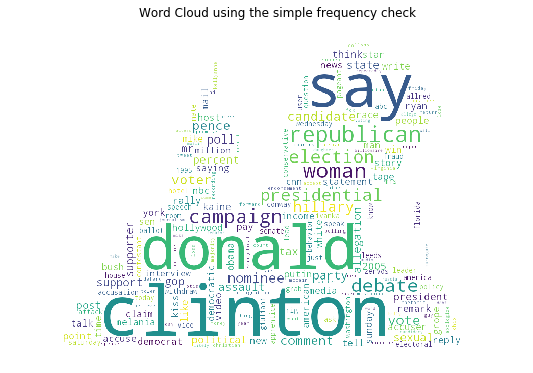

In [166]:
# convert the tuple list to dictionary
trump_dict = {}
for cnt in trump_cnter:
    if cnt[0] and cnt[0] != 'trump':
        trump_dict[cnt[0]] = cnt[1]
wc.fit_words(trump_dict)
plt.figure(figsize=(24,6))
plt.imshow(wc)
plt.axis('off')
plt.title('Word Cloud using the simple frequency check')
plt.show()

##### 6.2 Cosine Similarity Check

###### Brief Introduction:
As we have obtained the TF-IDF matrix, we use the words' existence in documents as the word features. The size of the word vector will be the number of documents. In each document, the score of the keyword will be defined as:

$$Score_x = \sum_{doc=1}^{sizeOfDoc} TFIDF_{trump}[doc]*TFIDF_x[doc]$$

In [150]:
def generatePairs(originList):
    """
    This function is used to generate the pair between trump and other word
    origin list: a row of tf-idf
    """
    
    # get the copy of the new list
    newList = {}
    
    # find trump first
    trumpVal = [pair[1] for pair in originList if pair and pair[0] == 'trump'][0]
    
    # multiply trump val with others
    for pair in originList:
        if pair and pair[0] != 'trump':
            newList[pair[0]] = pair[1] * trumpVal
    return newList

In [151]:
def calculateScore(word, wordlists):
    """
    this function is used to calculate the word score
    word: str
    wordlist: list of tuple
    """
    
    score = 0.0
    cnt = 0
    for wordlist in wordlists:
        cnt += 1
        score += wordlist[word] if word in wordlist else 0.0
    return score

In [152]:
keyword_lists = trump_keyword.apply(lambda x: generatePairs(x.values), axis=1)

In [153]:
keyword_lists.head(10)

Id
14642538    {'horry': 0.11684866346758498, 'county': 0.041...
14645950    {'schwartz': 0.09867669674414702, 'art': 0.077...
14645980    {'capitalism': 0.13801260863104692, 'dreher': ...
14645984    {'tax': 0.0937228407702808, 'obama': 0.0924902...
14647956    {'melanie': 0.1520039686015642, 'kevin': 0.042...
14648467    {'nyt': 0.17255222184031652, '1995': 0.1541670...
14648476    {'tax': 0.18835406955730005, '1995': 0.0883555...
14648493    {'tax': 0.08888410545883979, 'jones': 0.079465...
14648502    {'naacp': 0.0974288919473339, 'oath': 0.093850...
14648518    {'tax': 0.16352043544024358, 'document': 0.125...
dtype: object

In [154]:
scoreDict = {}
for word in tfidf_top20_Nameset:
    tmp = calculateScore(word, keyword_lists)
    if tmp:
        scoreDict[word] = tmp

In [157]:
score_sorted = sorted(scoreDict.items(), key=lambda x: x[1], reverse=True)

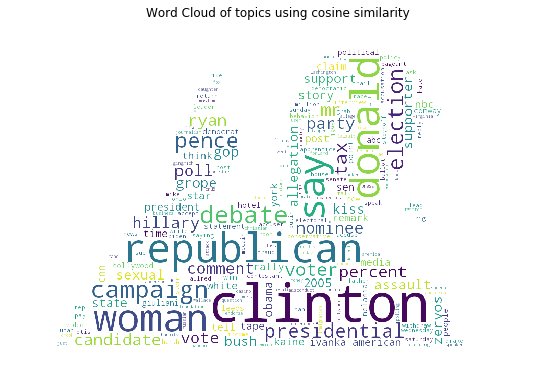

In [165]:
wc.fit_words(scoreDict)
plt.figure(figsize=(24,6))
plt.imshow(wc)
plt.axis('off')
plt.title('Word Cloud of topics using cosine similarity')
plt.show()

In [167]:
# load the state list
with open('state.txt', 'r') as f:
    states = f.read().lower().split('\n')

In [168]:
state_score = [i for i in score_sorted if i[0] in states]

In [169]:
state_dic = {}
for state in state_score:
    state_dic[state[0]] = state[1]

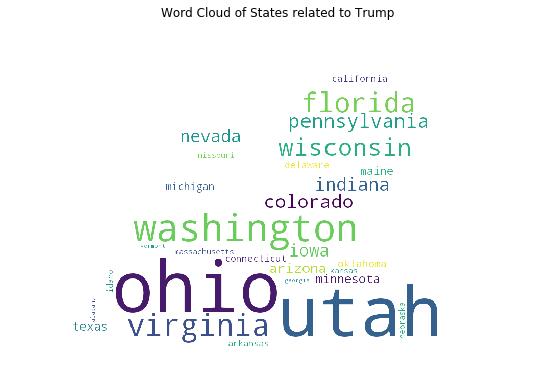

In [173]:
wc.fit_words(state_dic)
plt.figure(figsize=[24, 6])
plt.imshow(wc)
plt.axis('off')
plt.title('Word Cloud of States related to Trump')
plt.show()

In [175]:
# load city list
with open('cities.txt', 'r') as f:
    cities = f.read().lower().split()

cities_score = [i for i in score_sorted if i[0] in cities]
    
cities_dic = {}
for city in cities_score:
    cities_dic[city[0]] = city[1]

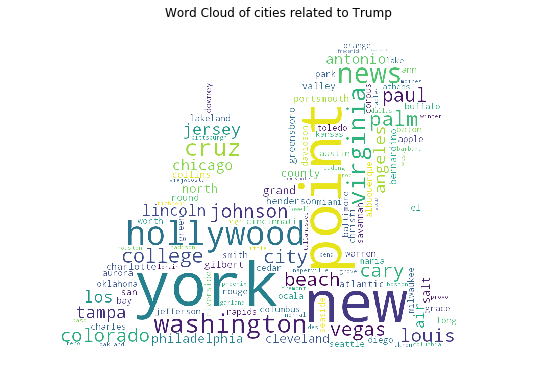

In [176]:
wc.fit_words(cities_dic)
plt.figure(figsize=[24, 6])
plt.imshow(wc)
plt.axis('off')
plt.title('Word Cloud of cities related to Trump')
plt.show()

In [177]:
# load English Name
with open('english_name.txt', 'r') as f:
    names = f.read().lower().split()

In [178]:
names_score = [idx for idx in score_sorted if idx[0] in names]

name_dic = {}
for name in names_score:
    name_dic[name[0]] = name[1]

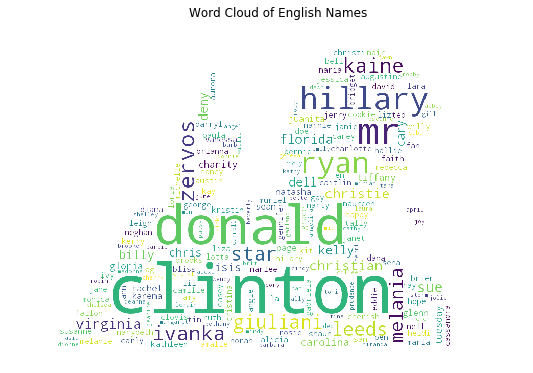

In [180]:
wc.fit_words(name_dic)
plt.figure(figsize=[24, 6])
plt.imshow(wc)
plt.axis('off')
plt.title('Word Cloud of English Names')
plt.show()

In [185]:
# remove names, cities, states
topic_other = [topic for topic in score_sorted \
               if topic[0] not in states and \
               topic[0] not in cities and \
               topic[0] not in names and \
               len(topic[0]) >= 5]

In [187]:
topic_other_dic = {}
for word, value in topic_names:
    topic_other_dic[word] = value

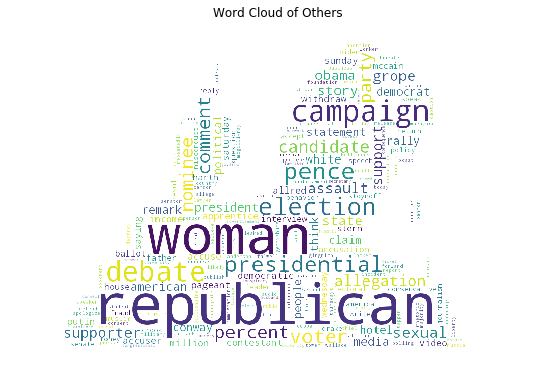

In [189]:
wc.fit_words(topic_other_dic)
plt.figure(figsize=[24, 6])
plt.imshow(wc)
plt.axis('off')
plt.title('Word Cloud of Others')
plt.show()

##### 6.3 Latent Dirichlet allocation for topic detection

This part refer to the tutorial in Week 12.

In [193]:
# load the spacy module
nlp = spacy.load('en')

In [194]:
# get the raw text
trump_chunks = list(trump_txt['txt'])

In [195]:
STOPWORDS = spacy.lang.en.stop_words.STOP_WORDS
processed_docs = list()
for doc in nlp.pipe(trump_chunks, n_threads=5, batch_size=10):

    # Process document using Spacy NLP pipeline.
    ents = doc.ents  # Named entities

    # Keep only words (no numbers, no punctuation).
    # Lemmatize tokens, remove punctuation and remove stopwords.
    doc = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]

    # Remove common words from a stopword list and keep only words of length 3 or more.
    doc = [token for token in doc if token not in STOPWORDS and len(token) > 2]

    # Add named entities, but only if they are a compound of more than word.
    doc.extend([str(entity) for entity in ents if len(entity) > 1])

    processed_docs.append(doc)
docs = processed_docs
del processed_docs

In [196]:
# Add bigrams too
from gensim.models.phrases import Phrases

# Add bigrams to docs (only ones that appear 15 times or more).
bigram = Phrases(docs, min_count=15)

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

/home/fcai/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [197]:
# Create a dictionary representation of the documents, and filter out frequent and rare words.
from gensim.corpora import Dictionary
dictionary = Dictionary(docs)

# Remove rare and common tokens.
# Filter out words that occur too frequently or too rarely.
max_freq = 0.3
min_wordcount = 3
dictionary.filter_extremes(no_below=min_wordcount, no_above=max_freq)

# Bag-of-words representation of the documents.
corpus = [dictionary.doc2bow(doc) for doc in docs]
#MmCorpus.serialize("models/corpus.mm", corpus)

print('Number of unique tokens: %d' % len(dictionary))
print('Number of chunks: %d' % len(corpus))

Number of unique tokens: 10794
Number of chunks: 994


In [198]:
# models
import random
seed = 42
random.seed(seed)
np.random.seed(seed)

from gensim.models import LdaMulticore
params = {'passes': 10, 'random_state': seed}
base_models = dict()
model = LdaMulticore(corpus=corpus, num_topics=10, id2word=dictionary, workers=6,
                passes=params['passes'], random_state=params['random_state'])

In [199]:
model.show_topics(num_words=5)

[(0,
  '0.012*"times" + 0.008*"allegation" + 0.007*"kiss" + 0.005*"room" + 0.005*"grope"'),
 (1,
  '0.007*"pence" + 0.006*"saturday" + 0.005*"mike" + 0.005*"ryan" + 0.005*"house"'),
 (2,
  '0.004*"obama" + 0.004*"email" + 0.003*"rig" + 0.003*"result" + 0.003*"policy"'),
 (3,
  '0.019*"percent" + 0.012*"poll" + 0.006*"lead" + 0.006*"white" + 0.005*"likely"'),
 (4,
  '0.030*"tax" + 0.013*"million" + 0.011*"pay" + 0.008*"income" + 0.008*"times"'),
 (5,
  '0.005*"ryan" + 0.004*"bill" + 0.004*"house" + 0.003*"white" + 0.003*"attack"'),
 (6,
  '0.007*"bush" + 0.005*"kiss" + 0.005*"star" + 0.005*"hollywood" + 0.005*"zervos"'),
 (7,
  '0.004*"god" + 0.004*"tax" + 0.003*"world" + 0.003*"life" + 0.003*"thiel"'),
 (8,
  '0.011*"student" + 0.006*"liberty" + 0.006*"teacher" + 0.005*"school" + 0.004*"falwell"'),
 (9,
  '0.025*"pence" + 0.013*"kaine" + 0.005*"vice" + 0.005*"obama" + 0.005*"vice_presidential"')]

In [200]:
model.show_topic(1,10)

[('pence', 0.0066984193),
 ('saturday', 0.0062775803),
 ('mike', 0.005195028),
 ('ryan', 0.0049188435),
 ('house', 0.004897883),
 ('friday', 0.004762443),
 ('remark', 0.0043625375),
 ('withdraw', 0.0042949747),
 ('john', 0.0038517807),
 ('mccain', 0.003813328)]

In [201]:
# convert score_sorted to dic
score_dict = {}
for i in score_sorted:
    score_dict[i[0]] = i[1]

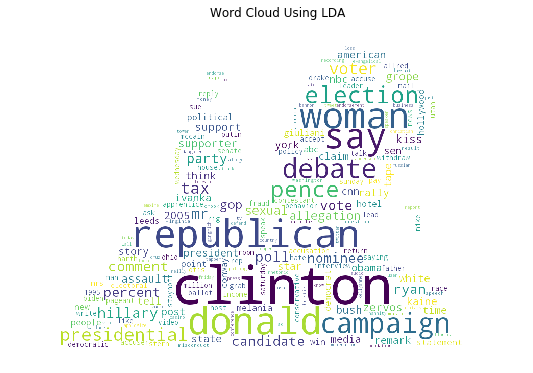

In [204]:
wc.fit_words(score_dict)
plt.figure(figsize=[24, 6])
plt.imshow(wc)

plt.axis("off")
plt.title('Word Cloud Using LDA')
plt.show()

In [ ]:
After our searching about the news during that time period, we select .... as our topic

### Part7: Explore in Other Topics

#### Todo:
1. According to the keywords, select the topics with strong relation. Specifically, we will focus on Trump, Clinton and Republician.
2. Follow the same steps in above parts to analyze the polarity of the medias in different but relative topics. For example, we will find out how the polarity scores of the medias change over time in a set of topics, such as election, immigration and Trump. We can compare the trend in different topics with strong and week relation.

##### 6.1 Helper Functions and pre-loading

In [206]:
# load all doc in august, september and 
source2=pd.read_csv(os.path.join(src_folder, src_file), delimiter="\t", header=None, encoding = "ISO-8859-1")
source2.columns=['id','unknown','date','country','media','website','title']

df=source2[source2['country']=='US']
US_top_30_media = ['CNN', 'New York Times', 'Washington Post', 'Breitbart News','Fox News','Huffington Post','VICE' ,'USA TODAY', 'NPR','CBS News'
                  ,'Houston Chronicle', 'NBC News','Politico','The Atlantic','TIME',  'Newsweek', 'ABC News','Reuters','Slate Magazine','Daily Beast', 
                  'Los Angeles Times','Quartz',  'New York Post']

df[df['media'].str.contains('New York Post')].head()
df['media']=df['media'].apply(lambda x: 'Slate Magazine' if 'slate'in x.lower() else x)

# store the result in a csv file
df.to_csv('top30mediaUS.csv')
data=pd.read_csv('top30mediaUS.csv')

/home/fcai/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [244]:
def getNameIndex(topic):
    """
        In this function, we will generate a list of news index to track the topic in August, September, and October
    """
    
    # load the data for august first
    with open('tfidf-08-top20-key.pickle', 'rb') as f:
        top20_key08 = pickle.load(f)
    
    with open('tfidf-08-ind-list.pickle', 'rb') as f:
        ind_list08 = pickle.load(f)
    
    
    # load the data for september
    with open('tfidf-09-top20-key.pickle', 'rb') as f:
        top20_key09 = pickle.load(f)
    
    with open('tfidf-09-ind-list.pickle', 'rb') as f:
        ind_list09 = pickle.load(f)
    
    # load the data for october
    with open('tfidf-10-top20-key.pickle', 'rb') as f:
        top20_key10 = pickle.load(f)
    
    with open('tfidf-10-ind-list.pickle', 'rb') as f:
        ind_list10 = pickle.load(f)
    
    namelist08 = [ind_list08[i] for i in range(len(ind_list08)) if sum([1 if topic in word else 0 for word in top20_key08[i]])]
    namelist09 = [ind_list09[i] for i in range(len(ind_list09)) if sum([1 if topic in word else 0 for word in top20_key09[i]])]
    namelist10 = [ind_list10[i] for i in range(len(ind_list10)) if sum([1 if topic in word else 0 for word in top20_key10[i]])]
    
    return namelist08 + namelist09 + namelist10

In [120]:
def load_data_source(year, month, country):
    '''
    Get news data after filtering
    Params: 
            year: str
            month: str
            country: str
    Return: data_country_year_month_sorted: dataframe
    '''
    #load data from now_sources_pt
    #new_src = pd.read_csv(now_sources_pt, delimiter="\t", header=None, encoding = "ISO-8859-1")
    new_src = pd.read_csv('top30mediaUS.csv')
    new_src = new_src.drop(['Unnamed: 0'],axis=1)
    #new_src.columns=['id','unknown','date','country','media','website','title']
    
    #split the column date into three new columns
    new_src['year'], new_src['month'], new_src['day'] = new_src['date'].str.split('-', 2).str
    #filter by country
    new_src_us = new_src[new_src['country'] == country]
    #filter by date

    if isinstance(month, list):
        data_country_year_month = new_src_us[(new_src_us['year'] == year) & (new_src_us['month'].isin(month))]
        data_country_year_month_sorted = data_country_year_month.sort_values(by = 'id')
    else:
        data_country_year_month = new_src_us[(new_src_us['year'] == year) & (new_src_us['month'] == month)]
        data_country_year_month_sorted = data_country_year_month.sort_values(by = 'id')
    
    return data_country_year_month_sorted

In [121]:
def hist_polarity(X_news, pickle_list_name):
    '''
    plot the histogram of mean of media polarity
    Params: X_news: dataframe
    Return:
    '''
    
    # Visualize the polarity
    X_news['polarity'].hist(bins=30, grid=True)
    plt.title('Histogram of Mean of Media Polarity')
    plt.xlabel('Polarity')
    plt.ylabel('Number of media')

In [122]:
def polarity_same_media(X_news, pickle_list_name, threshold):
    '''
    Collect polarity of news from same media and visualize the distribution
    Params: X_news: dataframe
            pickle_list_name: str
    Return: polarity
    '''
    
    # collect polarity of news from same media
    X_media = X_news.groupby('media')['polarity'].apply(np.array)
    
    X_media = X_media.to_frame()

    X_media_top = X_media[X_media['polarity'].apply(lambda x: len(x)) > threshold].copy()
    
    # Get universal mean of polarity of representative news
    media_count = X_media_top['polarity'].apply(len)

    media_mean = X_media_top['polarity'].apply(np.mean)

    mean_polarity = np.sum(media_count * media_mean) / np.sum(media_count)
    
    # Normalize the polarity
    X_media_top['normalized_polarity'] = X_media_top['polarity'] - mean_polarity    
    
    # add tags for each articles per media
    X_media_top_tag =  add_tag_to_article(X_media_top, pickle_list_name)
    
    # Visualize the polarity of media
    data = X_media_top['normalized_polarity'].values

    index = X_media_top.index

    plt.rcParams['figure.figsize'] = (20, 6)
    plt.boxplot(list(data))
    plt.xticks(np.arange(len(index)) + 1, index, rotation=45)
    plt.ylim(-1.25, 1.25)
    plt.ylabel('Polarity')
    plt.title('Polarity of news related to '+pickle_list_name+' in main stream media')

    return X_media_top_tag

In [123]:
def explore_media_polarity(pickle_list_name, data, txt_pd, threshold):
    '''
    Explore on media polarity about a particular keyword
    Params: pickle_list_name: str
            data: dataframe
            txt_pd: dataframe
    '''
    
    # Obtain list of index of news with keyword X
    X_list = getNameIndex(pickle_list_name)
    
    # Obtain dataframe of news with keyword X
    mask = data['id'].isin(X_list)
    data_X = data.loc[mask]
    
    # Filter out news not from polular media
    mask = data_X['media'].isin(US_top_30_media)
    data_X = data_X.loc[mask]    
    
    # Convert index of txt_pd to int type
    txt_pd.index = txt_pd.index.astype(int)
    
    # Get news focus on keyword X by merging the related ids with news df
    X_news = data_X.merge(txt_pd, left_on='id', right_index = True)
    
    # Find polarity of news 
    X_news['polarity'] = find_polarity_tags(X_news['txt'])
    
    # Visualize the polarity
    hist_polarity(X_news, pickle_list_name)

    # collect polarity of news from same media and visualize the polarity
    mediaTop10 = polarity_same_media(X_news, pickle_list_name, threshold)
    
    # Store data for further usage
    X_news.to_pickle('pickle_list_name_news_polar.pickle')
    
    return mediaTop10

In [124]:
def add_tag_to_article(dataframe, dataframe_name):
    '''
    add tags for a list of articles per media
    Params: dataframe: dataframe
            dataframe_name: str
    Return: dataframe_tag: dataframe
    '''
    
    dataframe_tag = dataframe.copy()
    
    dataframe_tag['tags'] = dataframe_tag['normalized_polarity'].apply(lambda x: tag_acticles(x, 0.2, -0.2))
    dataframe_tag['pos'] = dataframe_tag['tags'].apply(lambda x: tag_proportion(x)[0])
    dataframe_tag['neu'] = dataframe_tag['tags'].apply(lambda x: tag_proportion(x)[1])
    dataframe_tag['neg'] = dataframe_tag['tags'].apply(lambda x: tag_proportion(x)[2])
    dataframe_tag.to_csv(dataframe_name+'_10_freq_media_norm_tag.csv')
    return dataframe_tag

In [321]:
# Build topics to be investigated
topics = ['Trump', 'Clinton', 'Republic']

In [125]:
# Get the list of index of republic
republic_list = [ind_list[i] for i in range(num_doc) if sum([1 if 'republic' in word else 0 for word in tfidf_top20_key[i]])]

In [172]:
# Load txt in
txt = pd.read_pickle('txt-08-09-10.pickle')

In [181]:
# Load data in
data_US_16_10 = load_data_source('16', ['08', '09', '10'], 'US')


Check point 2  16
Check point 1  16


,polarity,normalized_polarity,tags,pos,neu,neg
media,,,,,,
ABC News,"[0.35, -0.06666666666666665, 0.177033492822966...","[0.01195574258177634, -0.4047109240848903, -0....","[0.0, -1.0, 0.0, -1.0, 0.0, -1.0, 1.0, 0.0, 0....",0.153846,0.538462,0.307692
CBS News,"[0.0, 0.2777777777777778, 0.051282051282051266...","[-0.33804425741822364, -0.06026647964044585, -...","[-1.0, 0.0, -1.0, -1.0, 1.0, 0.0]",0.166667,0.333333,0.500000
CNN,"[0.6746031746031746, 0.2857142857142857, 0.121...","[0.336558917184951, -0.05232997170393794, -0.2...","[1.0, 0.0, -1.0, 0.0, -1.0, 0.0]",0.166667,0.500000,0.333333
Fox News,"[0.07058823529411765, -0.5714285714285714, 0.7...","[-0.267456022124106, -0.909472828846795, 0.411...","[-1.0, -1.0, 1.0, 1.0, 1.0, 0.0, 1.0]",0.571429,0.142857,0.285714
Huffington Post,"[0.4, -0.6666666666666666, -0.625, 0.642857142...","[0.061955742581776385, -1.0047109240848902, -0...","[0.0, -1.0, -1.0, 1.0, 0.0, 0.0, 0.0, 0.0, -1....",0.076923,0.461538,0.461538
Los Angeles Times,"[-1.0, 0.10784313725490195, -0.095238095238095...","[-1.3380442574182236, -0.23020112016332167, -0...","[-1.0, -1.0, -1.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0...",0.200000,0.500000,0.300000
NPR,"[0.7424242424242424, 0.3384615384615385, 0.562...","[0.4043799850060188, 0.0004172810433148433, 0....","[1.0, 0.0, 1.0, 0.0, 0.0, -1.0, 0.0, 1.0, 0.0,...",0.500000,0.416667,0.083333
New York Post,"[0.375, 0.0, -0.04999999999999999, 0.175]","[0.03695574258177636, -0.33804425741822364, -0...","[0.0, -1.0, -1.0, 0.0]",0.000000,0.500000,0.500000
Politico,"[0.45080091533180777, 0.2553606237816764, -0.1...","[0.11275665791358414, -0.08268363363654724, -0...","[0.0, 0.0, -1.0, 0.0, 0.0, -1.0, 1.0, 0.0, 1.0...",0.363636,0.424242,0.212121


In [245]:
# Get data for trump
data_trump = explore_media_polarity('trump', data_US_16_10, txt, 2)

# Get data for clinton
data_clinton = explore_media_polarity('clinton', data_US_16_10, txt, 2)

# Get data for republic
data_republic = explore_media_polarity('republic', data_US_16_10, txt, 2)


Check point 2  17
Check point 1  17


In [195]:
# Get media intersection for all topics
inter_media = list(set(data_trump.index).intersection(set(data_clinton.index))\
                                        .intersection(set(data_republic.index))\
                                        .intersection(set(data_gun.index)))

In [316]:
# Illustrate the media interested in the topics that we are also interested in
inter_media

['USA TODAY',
 'NPR',
 'TIME',
 'Huffington Post',
 'Fox News',
 'ABC News',
 'CBS News',
 'Los Angeles Times',
 'New York Post',
 'Washington Post',
 'Slate Magazine']

In [317]:
# Combine polarity of different topics together
data_topics = data_trump[['pos', 'neg']].merge(data_clinton[['pos', 'neg']],
                                              left_index = True,
                                              right_index = True,
                                               suffixes = ['_trump', '_clinton'])\
                                        .merge(data_republic[['pos', 'neg']],
                                              left_index = True,
                                              right_index = True)

In [295]:
# Get the media that will be analyzed deeply
Selected_media = ['CNN', 'ABC News', 'Politico', 'Fox News']

In [303]:
# Get the data for the selected media
limited_data_topics = data_topics[(pd.Series(data_topics.index)\
                                .apply(lambda x: x in Selected_media)).values]

In [319]:
data_topics.rename(columns = {'pos' : 'pos_republic',
                             'neg' : 'neg_republic'},
                  inplace = True)

In [320]:
data_topics.head()

,pos_trump,neg_trump,pos_clinton,neg_clinton,pos_republic,neg_republic
media,,,,,,
ABC News,0.382716,0.296296,0.400000,0.300000,0.153846,0.307692
CBS News,0.317073,0.365854,0.240000,0.360000,0.166667,0.500000
CNN,0.272727,0.303030,0.190476,0.238095,0.166667,0.333333
Fox News,0.360000,0.560000,0.400000,0.485714,0.571429,0.285714
Huffington Post,0.333333,0.333333,0.352941,0.294118,0.076923,0.461538


In [326]:
# Visualize the tendency of polarity from same media on different topics

# Build data to plot
data_media_topics = list(data_topics.apply(lambda row: 
                                      go.Scatter(x = row.values[0: : 2],
                                                 y = row.values[1: : 2],
                                                 text = list(map(lambda topic:
                                                                 '({0}, {1})'.format(row.name,
                                                                                    topic),
                                                                 topics)),
                                                 textfont = dict(size = 6),
                                                 textposition = 'bottom center',
                                                 mode = 'markers+text',
                                                 name = row.name),
                                          axis = 1))

# Build layout for plot
layout_plot = go.Layout(title = 'Scatter of (media, topic) pairs over polarity',
                       xaxis = dict(title = 'Positive polarity',
                                   range = [0, 1]),
                       yaxis = dict(title = 'Negative polarity',
                                   range = [0, 1]))

In [327]:
# Create figure 
figure_media_topics = go.Figure(data = data_media_topics, layout = layout_plot)

In [329]:
# Show
# if it is not shown, please refer to data story, last two picture
py.iplot(figure_media_topics)

After investigating at distributions of polarity over different topics of specific media,
we now focus on distributions of polarity over specific topic.

In [158]:
# Build trace
trace_trump = go.Scatter(x = data_trump['pos'].values,
                         y = data_trump['neg'].values,
                         mode = 'markers+text',
                         text = '(' + data_trump.index + ', trump)',
                         textfont = dict(size = 6),
                         textposition = 'bottom center',
                         name = 'Trump')

trace_clinton = go.Scatter(x = data_clinton['pos'].values,
                           y = data_clinton['neg'].values,
                           mode = 'markers+text',
                           text = '(' + data_clinton.index + ', cliton)',
                           textfont = dict(size = 6),
                           textposition = 'bottom center',
                           name = 'Clinton')

trace_republic = go.Scatter(x = data_republic['pos'].values,
                            y = data_republic['neg'].values,
                            mode = 'markers+text',
                            text = '(' + data_republic.index + ', republic)',
                            textfont = dict(size = 6),
                            textposition = 'bottom center',
                           name = 'Republic')

In [271]:
# Build data for plot
data_plot = [trace_trump, trace_clinton, trace_republic]

# Build layout for plot
layout_plot = go.Layout(title = 'Scatter of (media, topic) pairs over polarity',
                       xaxis = dict(title = 'Positive polarity',
                                   range = [0, 1]),
                       yaxis = dict(title = 'Negative polarity',
                                   range = [0, 1]))

# Build figure
figure_plot = go.Figure(data = data_plot, layout = layout_plot)

# Show 
py.iplot(figure_plot, name = 'Polarity clustering')

### Part8: Conclusion

By investigating into the polarity of news just before the US election's polling date in 2016, some conventional judgments to the media are verified while some are challenged based on our analysis. Through out the whole process, we first successfully verified that Trump was the hottest topic during that periods. Then we observed the distinctions among media's attitudes towards this 'strange' president candidate. By focusing on the most related two entities with Trump, i.e., Clinton and Republican, and looking into the behaviors of four typical media in America, we eventually found out that public's conventional feeling that Politico tends to be neutral is correct and Fox is a solid supporter to Republican is correct. On the other hand, the so-called 'fake news' CNN as referred by Trump was not biased to some extent. 

As mentioned above, media is a forth power in the civilized society. We hope media is able to shoulder the responsiblity of reporting truth and objective.
